In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [21]:
df=pd.read_csv('D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES_with_features.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()
df['TES']=df['TES'].replace(0,1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2010-02-01 to 2025-04-01
Freq: MS
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TES              183 non-null    float64
 1   marrakech_lag_1  183 non-null    float64
 2   is_pandemic      183 non-null    float64
 3   review_count     183 non-null    float64
 4   NSI              183 non-null    float64
dtypes: float64(5)
memory usage: 8.6 KB


In [23]:
import plotly.express as px
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

In [24]:
df['TES_lag_1']=df['TES'].shift(1)
df.dropna(inplace=True)

### Holt-Winters Model Features

In [25]:
split=17
df_ts=df['TES']
train_ts = df_ts[:len(df_ts) - split]
hw_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_features = pd.DataFrame({'HW_Level': hw_model.level, 'HW_Trend': hw_model.trend, 'HW_Season': hw_model.season})
residuals = hw_model.fittedvalues - train_ts
n_forecast = split

# Get the last components from training
last_level = hw_model.level[-1]
last_trend = hw_model.trend[-1]
seasonality = hw_model.season[-12:]  # seasonal_periods = 12
forecast_index = pd.date_range(train_ts.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
# Build forecasted components manually
future_levels = [last_level + (i + 1) * last_trend for i in range(n_forecast)]
future_trends = [last_trend] * n_forecast
future_seasonality = [seasonality[i % 12] for i in range(n_forecast)]
#future_residuals = [0] * n_forecast  # Assuming unknown error = 0

hw_features_test = pd.DataFrame({
    'HW_Level': future_levels,
    'HW_Trend': future_trends,
    'HW_Season': future_seasonality,
    # 'HW_Residual': future_residuals
}, index=forecast_index)

hw_features = pd.concat([hw_features, hw_features_test])
hw_features.index = hw_features.index.tz_localize(None)
# Ensure both DataFrames have timezone-naive indexes before joining
df.index = df.index.tz_localize(None)
hw_features.index = hw_features.index.tz_localize(None)
# Join these new features with our main feature set
df = df.join(hw_features, how='left')
print("Holt-Winters components added as features.")


Holt-Winters components added as features.


C:\Users\masta\AppData\Local\Temp\ipykernel_10628\4003339438.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\masta\AppData\Local\Temp\ipykernel_10628\4003339438.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\masta\AppData\Local\Temp\ipykernel_10628\4003339438.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [26]:
l=list(df.columns)
l.remove('TES')
exog_variables=l#['marrakech_lag_1', 'review_count', 'NSI','is_pandemic','HW_Level','HW_Trend','HW_Season','TES_lag1','TES_lag2']


### Modling

In [27]:
train=df.loc[:'11-2023']
test=df.loc['12-2023':]

X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['TES']
y_test = test['TES']
print("taille du train:",len(train),"\ntaille du test :",len(test))

taille du train: 165 
taille du test : 17


In [28]:
from sklearn.model_selection import TimeSeriesSplit

def optimize_hyperparameters(X_train, y_train):
    """
    Optimise les hyperparamètres du Random Forest avec GridSearchCV
    adapté pour les séries temporelles
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # TimeSeriesSplit pour respecter l'ordre chronologique
    tscv = TimeSeriesSplit(n_splits=10,test_size=1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=tscv,  # Utilisation de TimeSeriesSplit au lieu de cv=5
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Meilleurs paramètres:", grid_search.best_params_)
    print("Meilleur score (MSE négatif):", grid_search.best_score_)
    
    return grid_search.best_params_

In [29]:
meilleur=optimize_hyperparameters(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score (MSE négatif): -376308458.19807994


In [30]:
model = RandomForestRegressor(
        n_estimators=meilleur["n_estimators"],
        max_depth=meilleur["max_depth"],
        min_samples_split=meilleur["min_samples_split"],
        min_samples_leaf=meilleur["min_samples_leaf"],
        random_state=42,
        n_jobs=-1
    )
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [31]:
model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
        )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [32]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


--- Random Forest Model Evaluation  ---
RMSE: 150,225.23
MAPE: 17.84%
MAE: 136,960.91
R²: -0.95


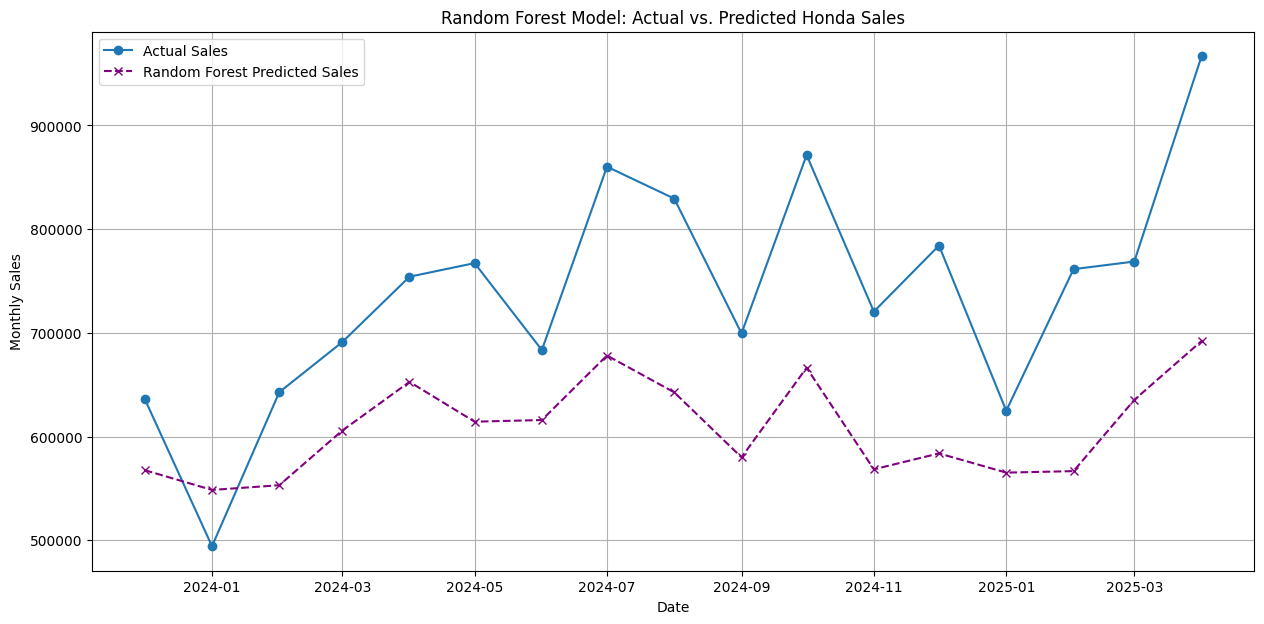


--- Analyzing Random Forest Feature Importance ---

Feature Importance (Sorted):


C:\Users\masta\AppData\Local\Temp\ipykernel_10628\4166700884.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




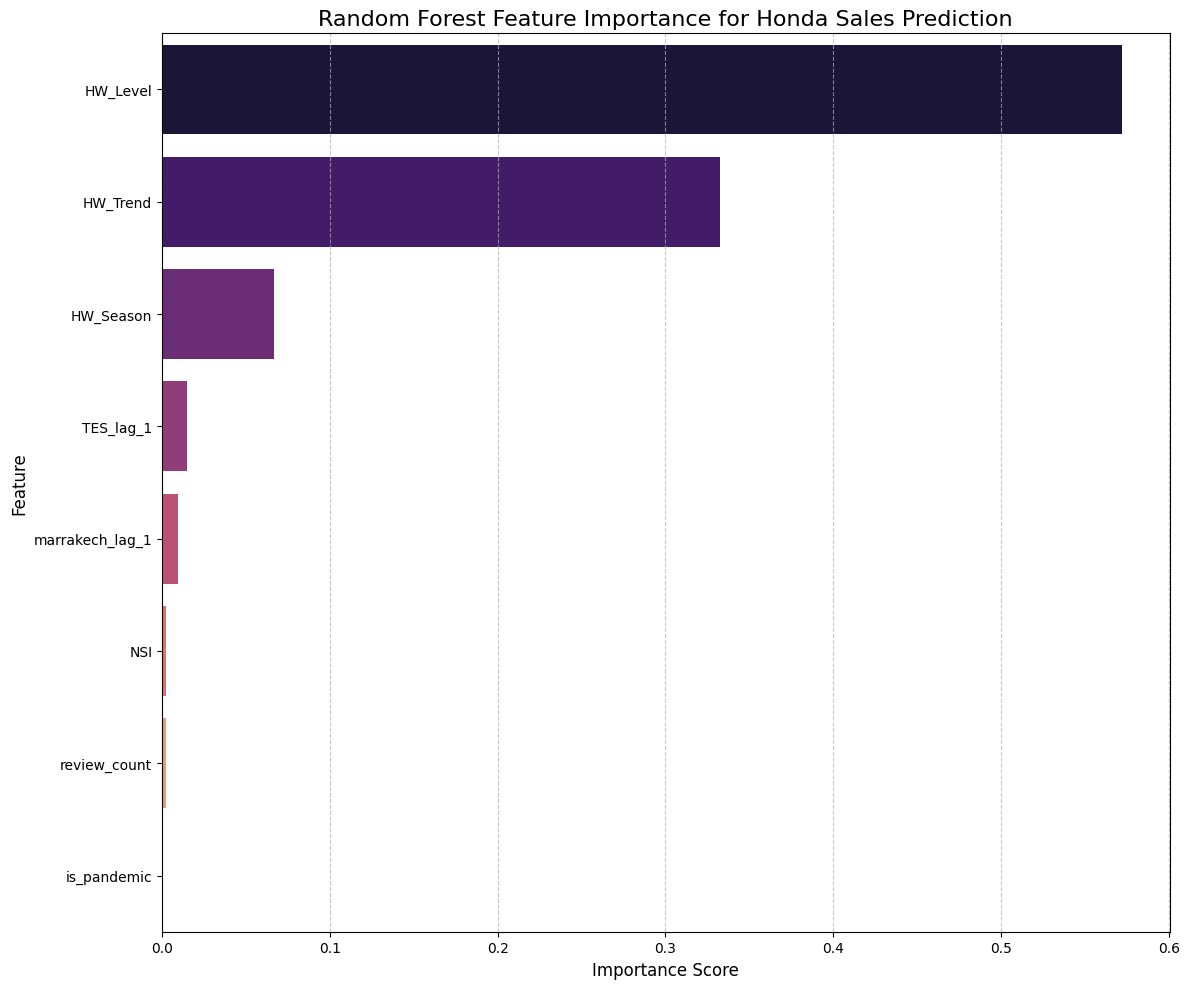

In [33]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Random Forest Model Evaluation  ---")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")
print(f"MAE: {mae:,.2f}")
print(f"R²: {r2:,.2f}")

# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Random Forest Predicted Sales', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()



print("\n--- Analyzing Random Forest Feature Importance ---")

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'feature': exog_variables,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Sorted):")
#print(importance_df.to_string())

# Plot the feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importance_df, palette='magma')
plt.title('Random Forest Feature Importance for Honda Sales Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Expanding window

In [34]:
# Préparer données


# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    l=list(df.columns)
    l.remove('TES')
    feats = l
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        X_train, y_train = train[feats], train[target]
        #meilleur=optimize_hyperparameters(X_train, y_train)
        model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # Test avec contrainte réelle
        test_row = df.iloc[train_end + i][feats].copy()
        
        pred = model.predict(pd.DataFrame([test_row]))[0]
        pred = model.predict(pd.DataFrame([test_row]))[0]
        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = np.sqrt(mean_squared_error(acts, preds))
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)


In [35]:
results = forecast(df, test=18)

======================================== le test némero  1 ========================================
======================================== le test némero  2 ========================================
======================================== le test némero  3 ========================================
======================================== le test némero  4 ========================================
======================================== le test némero  5 ========================================
======================================== le test némero  6 ========================================
======================================== le test némero  7 ========================================
======================================== le test némero  8 ========================================
======================================== le test némero  9 ========================================
======================================== le test némero  10 ========================================

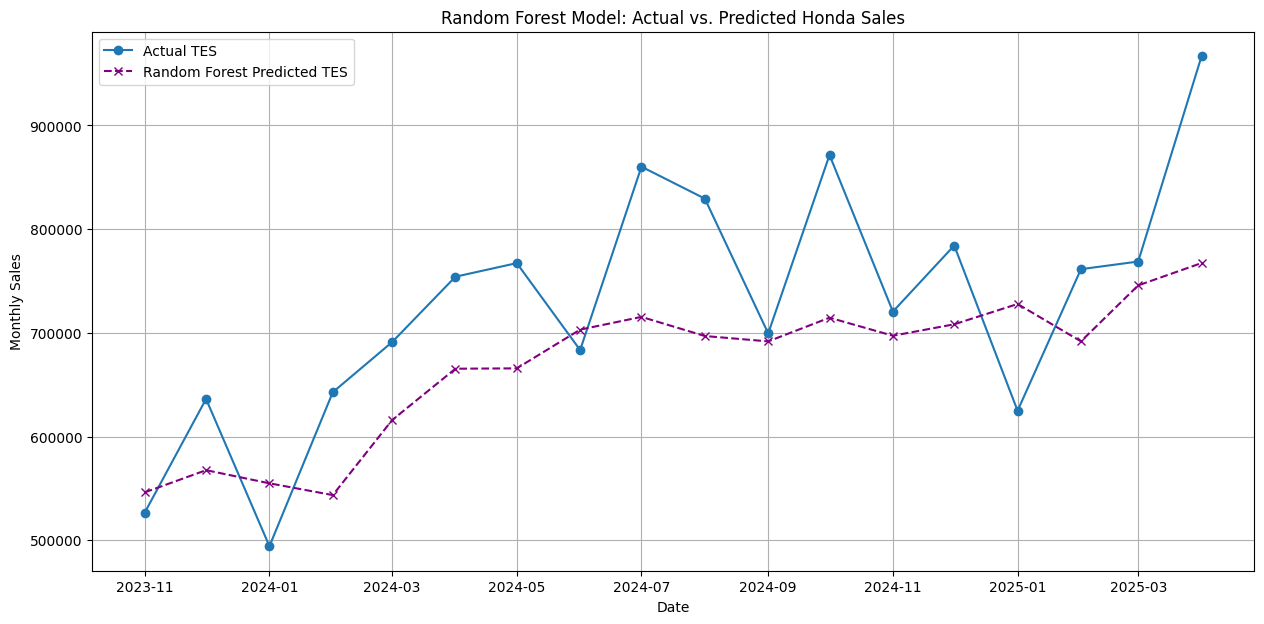

In [36]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results.index, results['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results.index, results['predicted'].values, label='Random Forest Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()